Importing the necessary libraries


In [ ]:
import pathlib
import tensorflow as tf
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt


Uploading the data




In [ ]:
path="drive/MyDrive/covid_cxr"

In [ ]:
labels = ['G1', 'G2']
img_size = 150
def get_data(data_dir):
    data = [] 
    class_num_arr=[]
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append(resized_arr)
                class_num_arr.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data),np.array(class_num_arr)

In [ ]:
dataset=get_data(path)

In [ ]:
dataset[0].shape

(21295, 150, 150, 3)

Splitting the dataset into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(dataset[0],dataset[1] ,random_state=104, shuffle=True)

In [ ]:
len(X_train)

15971

In [ ]:
len(X_test)

5324

In [ ]:
class_names = ['normal', 'pneumonia']

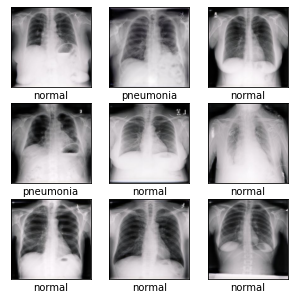

In [ ]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]])
plt.show()

Calling the Xception model

In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150,3),
    include_top=False)

In [ ]:
base_model.trainable = False

Replacing the last layers for classification

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,by passing `training=False`.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

Compiling and fitting the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model.fit(X_train,y_train,epochs=20)

Epoch 1/20
500/500 [==============================] - 12s 14ms/step - loss: 1.0959 - binary_accuracy: 0.7687
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.7728 - binary_accuracy: 0.8024
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6982 - binary_accuracy: 0.8116
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6293 - binary_accuracy: 0.8175
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5460 - binary_accuracy: 0.8294
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5785 - binary_accuracy: 0.8268
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5222 - binary_accuracy: 0.8376
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5716 - binary_accuracy: 0.8312
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5851 - binary_accuracy: 0.8301
Epoch 10/20
500/500 [======

Training and Validating using KFold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [ ]:
cross_val = KFold(shuffle=True, random_state=1)
fold_count = 1

In [ ]:
# For training epochs
epochs = 5

# For loss & acc plotting
histories = []

# For testing/evaluation acc scores
eval_scores = []

In [ ]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

for train, validation in cross_val.split(X_train):
    print("="*80)
    print("Fold-{}".format(fold_count))
    print("-"*80)
    print("Training & Validation")
    fold_count = fold_count + 1
    
    
    X_train1, y_train1 = X_train[train], y_train[train]
    X_val, y_val = X_train[validation], y_train[validation]
    
    history = model.fit(X_train1, y_train1,epochs=epochs,validation_data=(X_val, y_val))
    
    print("-"*80)
    print("Testing/evaluation")
    eval_loss, eval_accuracy = model.evaluate(X_test, y_test)
    
    histories.append(history)
    eval_scores.append(eval_accuracy)
    print("_"*80)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/5
400/400 [==============================] - 67s 156ms/step - loss: 0.4356 - accuracy: 0.8436 - val_loss: 0.3634 - val_accuracy: 0.8423
Epoch 2/5
400/400 [==============================] - 65s 162ms/step - loss: 0.2508 - accuracy: 0.8964 - val_loss: 0.1763 - val_accuracy: 0.9218
Epoch 3/5
400/400 [==============================] - 65s 163ms/step - loss: 0.1728 - accuracy: 0.9310 - val_loss: 0.2313 - val_accuracy: 0.8958
Epoch 4/5
400/400 [==============================] - 65s 162ms/step - loss: 0.0998 - accuracy: 0.9598 - val_loss: 0.0780 - val_accuracy: 0.9703
Epoch 5/5
400/400 [==============================] - 65s 162ms/step - loss: 0.0607 - accuracy: 0.9764 - val_loss: 0.0494 - val_accuracy: 0.9834
--------------------------------------------------------------------------------
Testing/evaluation
167/167 [==============================] - 2s 15ms/step - loss: 0.0492

In [ ]:
def display_kfold_result(history, k=1):
    # Train & Val Loss
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    # Train & Val Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(accuracy, label="Training")
    plt.plot(val_accuracy, label="Validation")
    plt.legend(loc="lower right")
    
    plt.suptitle("Fold-{}".format(k))
    plt.show()

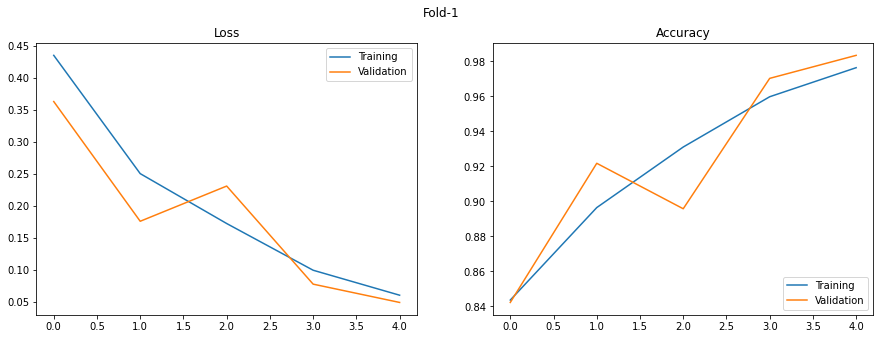

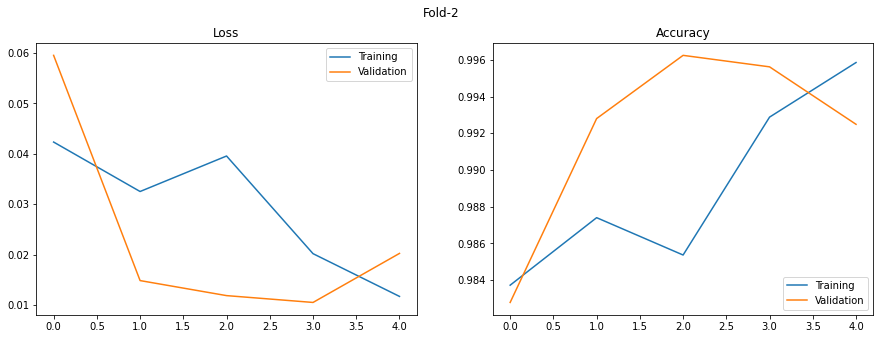

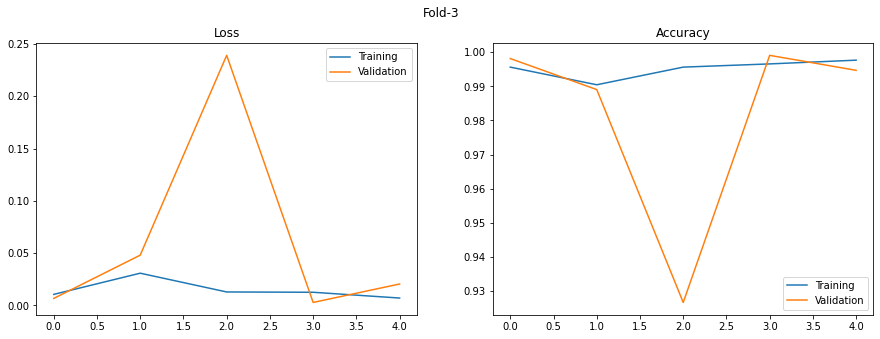

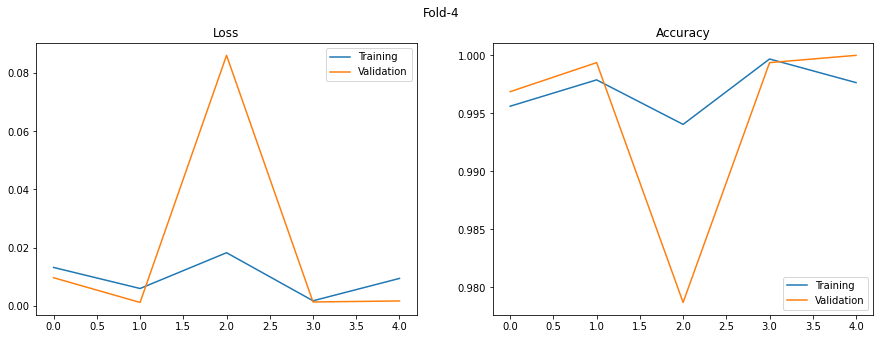

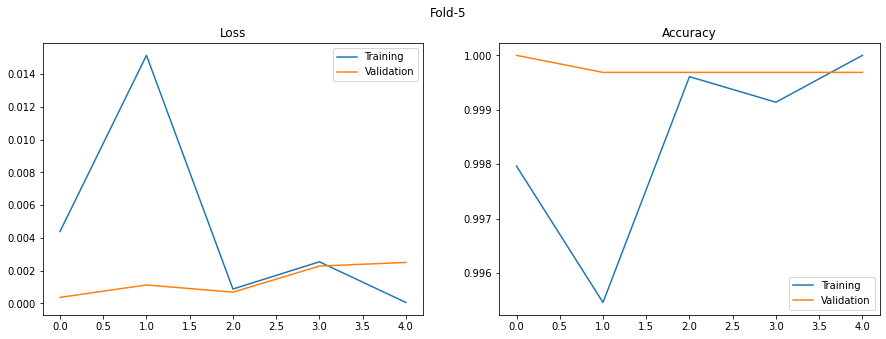

In [ ]:
for history in histories:
    display_kfold_result(history, (histories.index(history)+1))

In [ ]:
predictions =model.predict(X_test)


167/167 [==============================] - 3s 12ms/step


In [ ]:
ynew =np.where(predictions > 0.5, 1,0)

Generating Confusion matrix

In [ ]:
confusion_matrix(y_test, ynew)

array([[4114,    2],
       [   1, 1207]])